In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{3}"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from torchvision import transforms
import joblib
from torchsummary import summary
import pytorch_ssim
import wandb

/home/dg321/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Initial settings

In [3]:
lr=0.001

t0 = time.time()

print(t0)

root_path = '/home/dg321/gitTest/PRI/irp/FlowPassBuilding/'

1708363017.6541715


## Load building data

In [23]:
concatenated_data = np.load("/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data/InterpolatedResult256/FpB_Interpolated_t0_VelocityAbsorption_256_256.npy")
print(concatenated_data.shape)

(2, 256, 256)


In [24]:
concatenated_data_revalued = concatenated_data.copy()
concatenated_data_revalued[concatenated_data > 1500] = 1
concatenated_data_revalued[concatenated_data <= 1500] = 0

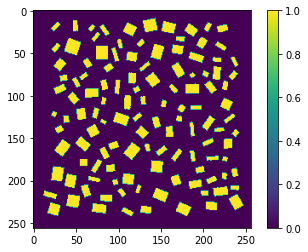

In [25]:
plt.imshow(concatenated_data_revalued[0,:,:])
plt.colorbar()

In [26]:
concatenated_data_revalued = concatenated_data_revalued[0,:,:].reshape(1,256,256)
print(concatenated_data_revalued.shape)

(1, 256, 256)


## Create data loader

In [27]:
dataloader = DataLoader(concatenated_data_revalued)

## Define the model

### latent_channel_number = 1

In [57]:
fist_hidden_layer = 16
second_hidden_layer = 32
latent_channel_number = 1


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, fist_hidden_layer, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(fist_hidden_layer, second_hidden_layer, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(second_hidden_layer, fist_hidden_layer, kernel_size=2, stride=1, padding=1),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(fist_hidden_layer, latent_channel_number, kernel_size=2, stride=1, padding=0),  
            nn.LeakyReLU(negative_slope=0.1)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_channel_number, fist_hidden_layer, kernel_size=2, stride=1, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose2d(fist_hidden_layer, second_hidden_layer, kernel_size=2, stride=1, padding=1),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose2d(second_hidden_layer, fist_hidden_layer, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose2d(fist_hidden_layer, 1, kernel_size=2, stride=2, padding=0),   
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [58]:
# Check if CUDA is available and set PyTorch to use GPU or CPU accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Instantiate the model
autoencoder = Autoencoder().to(device)

summary(autoencoder, (1,256, 256))
summary(autoencoder, (1,384, 384))
summary(autoencoder, (1,384*2, 384*2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]              80
         LeakyReLU-2         [-1, 16, 128, 128]               0
            Conv2d-3           [-1, 32, 64, 64]           2,080
         LeakyReLU-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 16, 65, 65]           2,064
         LeakyReLU-6           [-1, 16, 65, 65]               0
            Conv2d-7            [-1, 1, 64, 64]              65
         LeakyReLU-8            [-1, 1, 64, 64]               0
   ConvTranspose2d-9           [-1, 16, 65, 65]              80
        LeakyReLU-10           [-1, 16, 65, 65]               0
  ConvTranspose2d-11           [-1, 32, 64, 64]           2,080
        LeakyReLU-12           [-1, 32, 64, 64]               0
  ConvTranspose2d-13         [-1, 16, 128, 128]           2,064
        LeakyReLU-14         [-1, 16, 1

### latent_channel_number = 2

In [65]:
fist_hidden_layer = 16
second_hidden_layer = 32
latent_channel_number = 2


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, fist_hidden_layer, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(fist_hidden_layer, second_hidden_layer, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(second_hidden_layer, fist_hidden_layer, kernel_size=2, stride=1, padding=1),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(fist_hidden_layer, latent_channel_number, kernel_size=2, stride=1, padding=0),  
            nn.LeakyReLU(negative_slope=0.1)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_channel_number, fist_hidden_layer, kernel_size=2, stride=1, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose2d(fist_hidden_layer, second_hidden_layer, kernel_size=2, stride=1, padding=1),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose2d(second_hidden_layer, fist_hidden_layer, kernel_size=2, stride=2, padding=0),  
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose2d(fist_hidden_layer, 1, kernel_size=2, stride=2, padding=0),   
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [66]:
# Check if CUDA is available and set PyTorch to use GPU or CPU accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Instantiate the model
autoencoder = Autoencoder().to(device)

summary(autoencoder, (1,256, 256))
summary(autoencoder, (1,384, 384))
summary(autoencoder, (1,384*2, 384*2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]              80
         LeakyReLU-2         [-1, 16, 128, 128]               0
            Conv2d-3           [-1, 32, 64, 64]           2,080
         LeakyReLU-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 16, 65, 65]           2,064
         LeakyReLU-6           [-1, 16, 65, 65]               0
            Conv2d-7            [-1, 2, 64, 64]             130
         LeakyReLU-8            [-1, 2, 64, 64]               0
   ConvTranspose2d-9           [-1, 16, 65, 65]             144
        LeakyReLU-10           [-1, 16, 65, 65]               0
  ConvTranspose2d-11           [-1, 32, 64, 64]           2,080
        LeakyReLU-12           [-1, 32, 64, 64]               0
  ConvTranspose2d-13         [-1, 16, 128, 128]           2,064
        LeakyReLU-14         [-1, 16, 1

## Train the model

In [67]:
# Specify the IDs of the GPUs you want to use
# os.environ["CUDA_VISIBLE_DEVICES"] = "3,4"

# Initialize a new run
wandb.init(project="compression - building field")

# If there are multiple GPUs, wrap the model with nn.DataParallel
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    autoencoder = nn.DataParallel(autoencoder)

# Instantiate the model, loss function, and optimizer
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()  # Mean Squared Error loss works well for image reconstruction
# criterion = pytorch_ssim.SSIM(window_size = 11)  # Use SSIM loss
# def ssim_multichannel(img1, img2, window_size=11):
#     # Assume img1 and img2 are 4D tensors [batch_size, channels, height, width]
#     ssim_sum = 0
#     for i in range(img1.shape[1]):
#         ssim_sum += pytorch_ssim.ssim(img1[:, i, :, :].unsqueeze(1), img2[:, i, :, :].unsqueeze(1), window_size=window_size)
#         print(i)
#     return ssim_sum / img1.shape[1]  # Average over channels

optimizer = optim.Adam(autoencoder.parameters(), lr=lr)

num_epochs = 5000

# Optionally, you can add the following line to watch your model in wandb interface
wandb.watch(autoencoder)

# Training loop
for epoch in range(num_epochs):
    for data in dataloader:
        inputs = data.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        # loss = 1 - ssim_multichannel(outputs, inputs)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    # Log the loss to wandb
    wandb.log({"loss": loss.item()})

print("Training time:", time.time()-t0)

# Save the model weights to wandb
torch.save(autoencoder.state_dict(), "autoencoder.pth")
wandb.save("autoencoder.pth")

# Log the model's architecture
wandb.config.model_architecture = str(autoencoder)

# Create a new artifact
artifact = wandb.Artifact('model', type='model')

# Add the file to the artifact
artifact.add_file('autoencoder.pth')

# Save the artifact to Weights & Biases
wandb.log_artifact(artifact)

loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.00313


2024-02-19 17:46:19.837842: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Epoch [1/5000], Loss: 0.2228
Epoch [2/5000], Loss: 0.2223
Epoch [3/5000], Loss: 0.2219
Epoch [4/5000], Loss: 0.2214
Epoch [5/5000], Loss: 0.2209
Epoch [6/5000], Loss: 0.2204
Epoch [7/5000], Loss: 0.2199
Epoch [8/5000], Loss: 0.2194
Epoch [9/5000], Loss: 0.2189
Epoch [10/5000], Loss: 0.2184
Epoch [11/5000], Loss: 0.2179
Epoch [12/5000], Loss: 0.2174
Epoch [13/5000], Loss: 0.2169
Epoch [14/5000], Loss: 0.2163
Epoch [15/5000], Loss: 0.2158
Epoch [16/5000], Loss: 0.2152
Epoch [17/5000], Loss: 0.2145
Epoch [18/5000], Loss: 0.2139
Epoch [19/5000], Loss: 0.2132
Epoch [20/5000], Loss: 0.2124
Epoch [21/5000], Loss: 0.2116
Epoch [22/5000], Loss: 0.2108
Epoch [23/5000], Loss: 0.2099
Epoch [24/5000], Loss: 0.2090
Epoch [25/5000], Loss: 0.2080
Epoch [26/5000], Loss: 0.2069
Epoch [27/5000], Loss: 0.2058
Epoch [28/5000], Loss: 0.2045
Epoch [29/5000], Loss: 0.2032
Epoch [30/5000], Loss: 0.2018
Epoch [31/5000], Loss: 0.2004
Epoch [32/5000], Loss: 0.1988
Epoch [33/5000], Loss: 0.1970
Epoch [34/5000], Lo

## Load saved model

In [48]:
run = wandb.init()
artifact = run.use_artifact('guodh/compression - building field/model:v5', type='model')
artifact_dir = artifact.download()

# Load the model
autoencoder = Autoencoder()

# Load the model state dictionary from the downloaded artifact
autoencoder.load_state_dict(torch.load(os.path.join(artifact_dir, "autoencoder.pth")))

loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.00417


2024-02-19 17:36:46.335016: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


<All keys matched successfully>

## Generate result plots

### 6*6 domain

(1, 256, 256)
latent space shape torch.Size([1, 2, 64, 64])
(1, 1, 256, 256)


<Figure size 432x288 with 0 Axes>

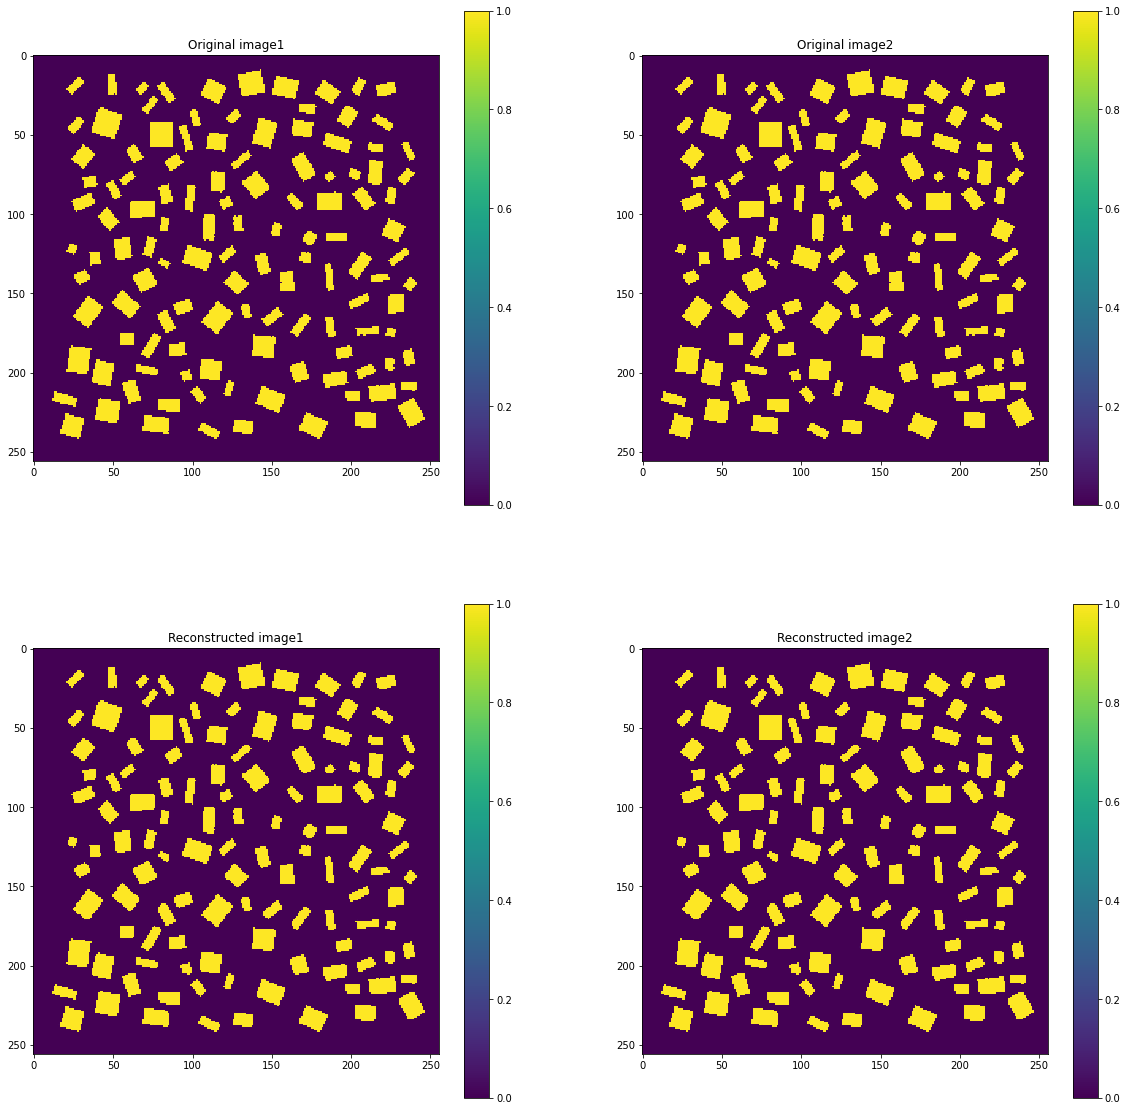

In [73]:
autoencoder.cpu().eval()

dataP = concatenated_data_revalued
print(dataP.shape)

size_start = 0
size_end = 256

plt.figure()

f, axarr = plt.subplots(2,2, figsize=(20, 20))

sub1 = axarr[0][0].imshow(np.rot90(dataP[0, size_start:size_end,size_start:size_end], 4), interpolation='none')
axarr[0][0].title.set_text('Original image1')
f.colorbar(sub1, ax=axarr[0][0])

sub2 = axarr[0][1].imshow(np.rot90(dataP[0, size_start:size_end,size_start:size_end], 4), interpolation='none')
axarr[0][1].title.set_text('Original image2')
f.colorbar(sub2, ax=axarr[0][1])

data_rotated = np.rot90(dataP[:, size_start:size_end,size_start:size_end], 4).copy()

input_data = torch.from_numpy(data_rotated).unsqueeze(0).float()
latent_space_output = autoencoder.encoder(input_data.view(1, 1, 256, 256))
print('latent space shape', latent_space_output.shape)
res = autoencoder(input_data.view(1, 1, 256, 256))
output_data = res.detach().numpy()
print(output_data.shape)

sub3 = axarr[1][0].imshow(output_data[0,0, :,:], interpolation='none')
axarr[1][0].title.set_text('Reconstructed image1')
f.colorbar(sub3, ax=axarr[1][0])

sub4 = axarr[1][1].imshow(output_data[0,0, :,:], interpolation='none')
axarr[1][1].title.set_text('Reconstructed image2')
f.colorbar(sub4, ax=axarr[1][1])

plt.show()

In [75]:
dataP = concatenated_data_revalued
size_start = 0
size_end = xysize

# Extract a region of interest and prepare it for input
data_rotated = dataP[:2, size_start:size_end, size_start:size_end].copy()
print(data_rotated.shape)
input_data = torch.from_numpy(data_rotated).unsqueeze(0).float()
print(input_data.shape)

# Pass the input through the encoder to get the latent variable
with torch.no_grad():
    latent_space_output = autoencoder.encoder(input_data)

print('Latent space shape:', latent_space_output.shape)

latent_space_output = latent_space_output.detach().numpy()


print(latent_space_output.shape)

(1, 256, 256)
torch.Size([1, 1, 256, 256])
Latent space shape: torch.Size([1, 2, 64, 64])
(1, 2, 64, 64)


In [76]:
datasetFolder = 'Flow_Data'
xysize = 256

savepath = '/home/dg321/gitTest/PRI/irp/FlowPassBuilding/' + datasetFolder + '/Latent_data_Building_{}_{}_26464.npy'.format(xysize, xysize)

np.save(savepath, latent_space_output)
print('Finished: ' + savepath)

Finished: /home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data/Latent_data_Building_256_256_26464.npy


### 9*9 domain

In [77]:
datasetFolder = 'Flow_Data_9_9'
xysize = 384

concatenated_data_384 = np.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data_9_9/FpB_Interpolated_VelocityAbsorption_384_384.npy')

print(concatenated_data_384.shape)

(2, 384, 384)


In [78]:
concatenated_data_revalued_384 = concatenated_data_384.copy()
concatenated_data_revalued_384[concatenated_data_384 > 1500] = 1
concatenated_data_revalued_384[concatenated_data_384 <= 1500] = 0

concatenated_data_revalued_384 = concatenated_data_revalued_384[0,:,:].reshape(1,xysize,xysize)

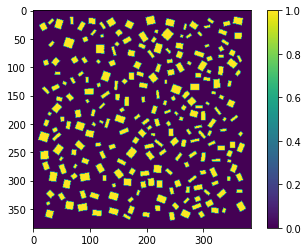

In [79]:
plt.imshow(concatenated_data_revalued_384[0,:,:])
plt.colorbar()

(1, 384, 384)
latent space shape torch.Size([1, 2, 96, 96])
(1, 1, 384, 384)


<Figure size 432x288 with 0 Axes>

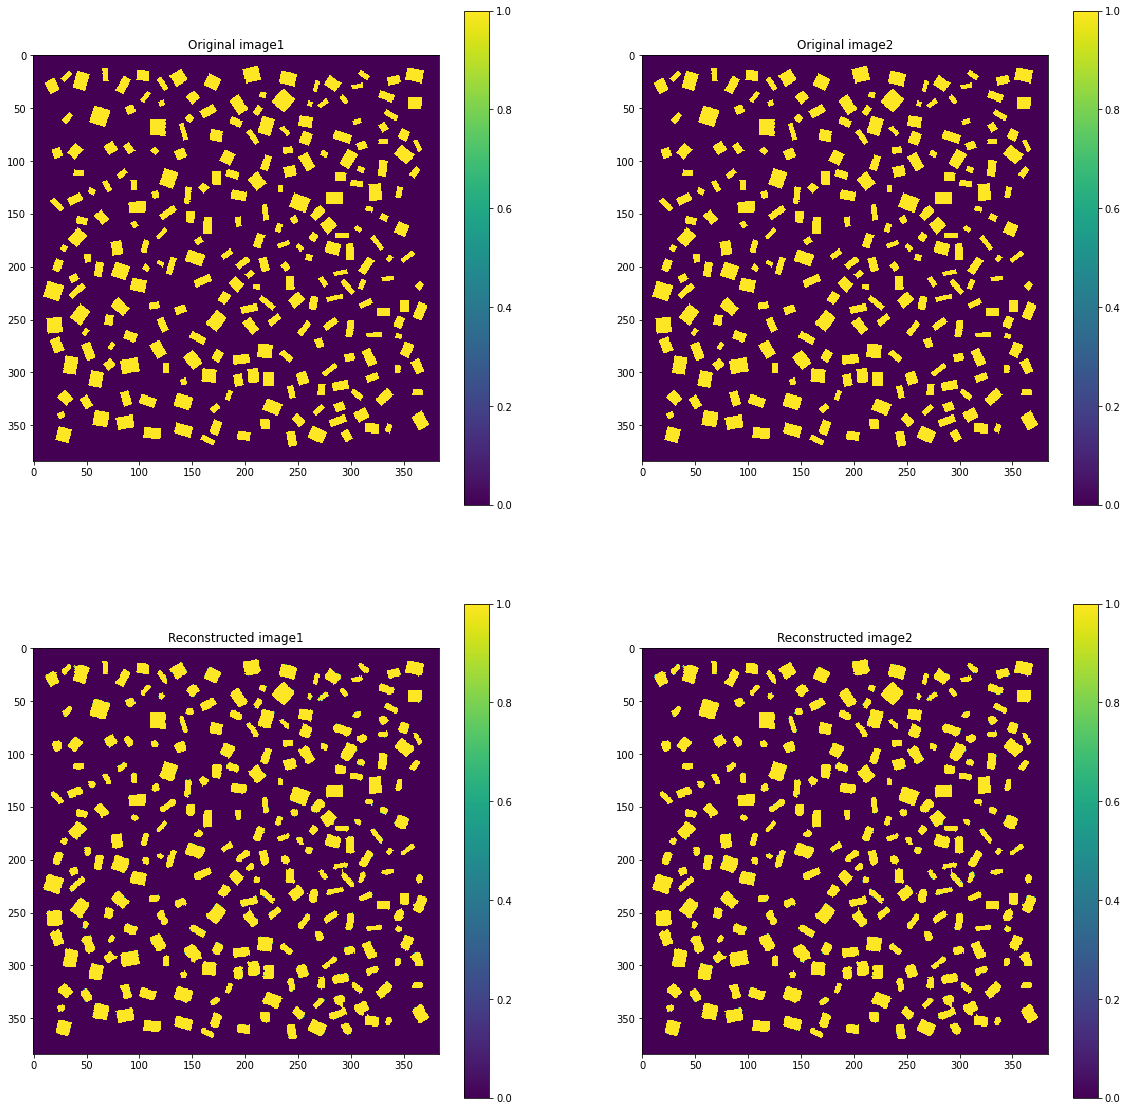

In [80]:
autoencoder.cpu().eval()

dataP = concatenated_data_revalued_384
print(dataP.shape)

size_start = 0
size_end = xysize

plt.figure()

f, axarr = plt.subplots(2,2, figsize=(20, 20))

sub1 = axarr[0][0].imshow(np.rot90(dataP[0, size_start:size_end,size_start:size_end], 4), interpolation='none')
axarr[0][0].title.set_text('Original image1')
f.colorbar(sub1, ax=axarr[0][0])

sub2 = axarr[0][1].imshow(np.rot90(dataP[0, size_start:size_end,size_start:size_end], 4), interpolation='none')
axarr[0][1].title.set_text('Original image2')
f.colorbar(sub2, ax=axarr[0][1])

data_rotated = np.rot90(dataP[:, size_start:size_end,size_start:size_end], 4).copy()

input_data = torch.from_numpy(data_rotated).unsqueeze(0).float()
latent_space_output = autoencoder.encoder(input_data.view(1, 1, xysize, xysize))
print('latent space shape', latent_space_output.shape)
res = autoencoder(input_data.view(1, 1, xysize, xysize))
output_data = res.detach().numpy()
print(output_data.shape)

sub3 = axarr[1][0].imshow(output_data[0,0, :,:], interpolation='none')
axarr[1][0].title.set_text('Reconstructed image1')
f.colorbar(sub3, ax=axarr[1][0])

sub4 = axarr[1][1].imshow(output_data[0,0, :,:], interpolation='none')
axarr[1][1].title.set_text('Reconstructed image2')
f.colorbar(sub4, ax=axarr[1][1])

plt.show()

In [81]:
dataP = concatenated_data_revalued_384
size_start = 0
size_end = xysize

# Extract a region of interest and prepare it for input
data_rotated = dataP[:2, size_start:size_end, size_start:size_end].copy()
print(data_rotated.shape)
input_data = torch.from_numpy(data_rotated).unsqueeze(0).float()
print(input_data.shape)

# Pass the input through the encoder to get the latent variable
with torch.no_grad():
    latent_space_output = autoencoder.encoder(input_data)

print('Latent space shape:', latent_space_output.shape)

latent_space_output = latent_space_output.detach().numpy()


print(latent_space_output.shape)

(1, 384, 384)
torch.Size([1, 1, 384, 384])
Latent space shape: torch.Size([1, 2, 96, 96])
(1, 2, 96, 96)


In [83]:
384*384/(2*96*96)

8.0

In [82]:
datasetFolder = 'Flow_Data_9_9'
xysize = 384

savepath = '/home/dg321/gitTest/PRI/irp/FlowPassBuilding/' + datasetFolder + '/Latent_data_Building_{}_{}_29696.npy'.format(xysize, xysize)

np.save(savepath, latent_space_output)
print('Finished: ' + savepath)

Finished: /home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data_9_9/Latent_data_Building_384_384_29696.npy
